In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose


import pmdarima as pm
from prophet import Prophet


# Part 1 : Exploratory Data Analysis (EDA) 

**Loading Dataset**

In [5]:
# Loading Dataset
df = pd.read_csv('./Data/DAYTON_hourly.csv')
df.head(5)

,Datetime,DAYTON_MW
0,2004-12-31 01:00:00,1596.0
1,2004-12-31 02:00:00,1517.0
2,2004-12-31 03:00:00,1486.0
3,2004-12-31 04:00:00,1469.0
4,2004-12-31 05:00:00,1472.0


**Missing Values**

In [6]:
print('Number of missing values:', df.isnull().sum())

Number of missing values: Datetime     0
DAYTON_MW    0
dtype: int64


In order to use the models provided by the stats library, we need to set the date column to be a data frame index.

In [7]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index).to_period("H")

# To ensure that dates are sorted 
df = df.sort_index()
print(df)

                  DAYTON_MW
Datetime                   
2004-10-01 01:00     1621.0
2004-10-01 02:00     1536.0
2004-10-01 03:00     1500.0
2004-10-01 04:00     1434.0
2004-10-01 05:00     1489.0
...                     ...
2018-08-02 20:00     2554.0
2018-08-02 21:00     2481.0
2018-08-02 22:00     2405.0
2018-08-02 23:00     2250.0
2018-08-03 00:00     2042.0

[121275 rows x 1 columns]


**Data Visualization**

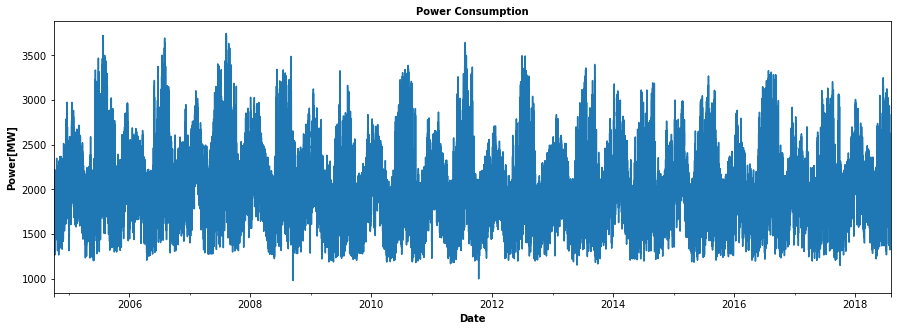

In [8]:
df.plot(kind='line',figsize=(15, 5),legend=False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Power Consumption",fontsize=10,fontweight='bold')
plt.xlabel('Date', fontsize=10,fontweight='bold') 
plt.ylabel('Power[MW]', fontsize=10,fontweight='bold') 
plt.show()

We then plot the power consumption for year 2017 to see if we can visibly find any pattern/seasonality. 

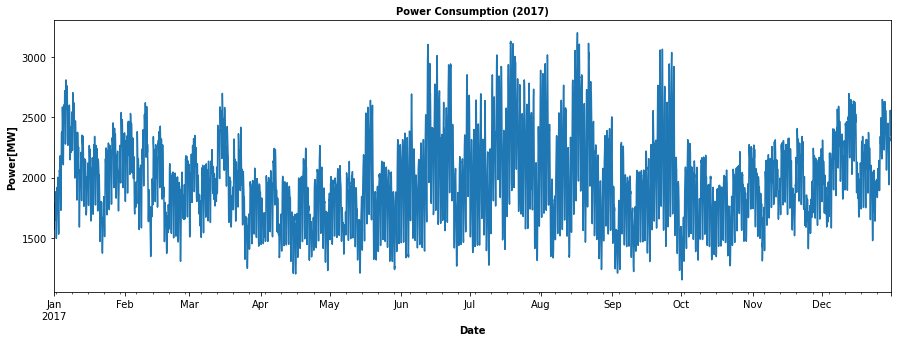

In [9]:
df_hourly_2017 = df[df.index >='2017-01-01 00:00']
df_hourly_2017= df_hourly_2017[df_hourly_2017.index <='2017-12-31 00:00']
df_hourly_2017.plot(kind='line',figsize=(15, 5),legend=False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Power Consumption (2017)",fontsize=10,fontweight='bold')
plt.xlabel('Date', fontsize=10,fontweight='bold') 
plt.ylabel('Power[MW]', fontsize=10,fontweight='bold') 
plt.show()

**Data Visualization At Different Sampling Period**

In [10]:
def SampledDataset(sample_type):
    
    if sample_type =='Hourly':
        df_sampled= df
        
    elif sample_type =='Monthly':
        df_sampled= df.resample('M').mean()
        
    elif sample_type =='Daily':
        df_sampled= df.resample('D').mean()
           
    else:
        df_sampled= df.resample('Y').mean()

    df_sampled.plot(kind='line',figsize=(15, 5),legend=False)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(sample_type,fontsize=10,fontweight='bold')
    plt.xlabel('Date', fontsize=10,fontweight='bold') 
    plt.ylabel('Power[MW]', fontsize=10,fontweight='bold') 
    plt.show()
    return df_sampled

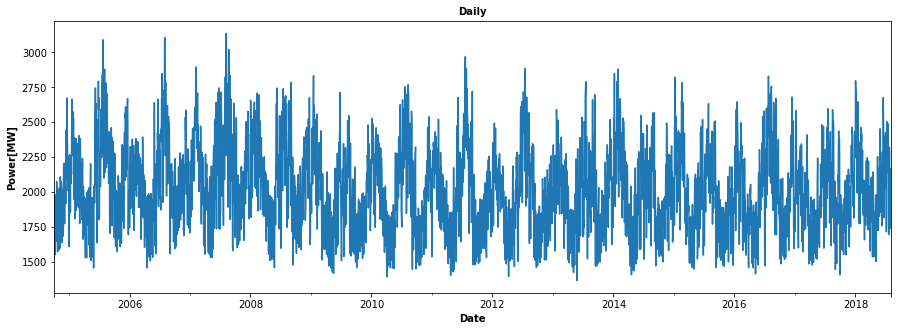

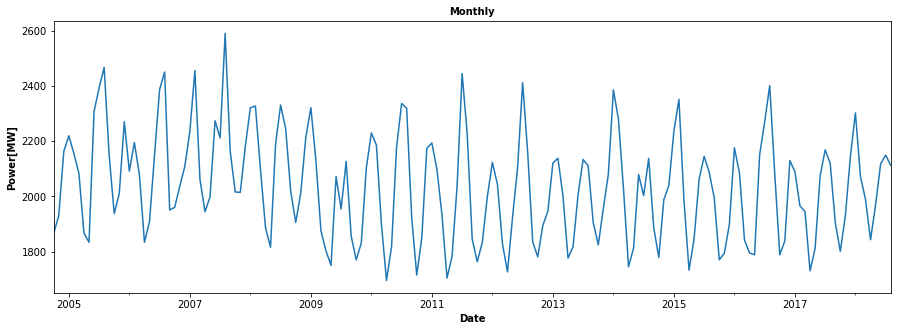

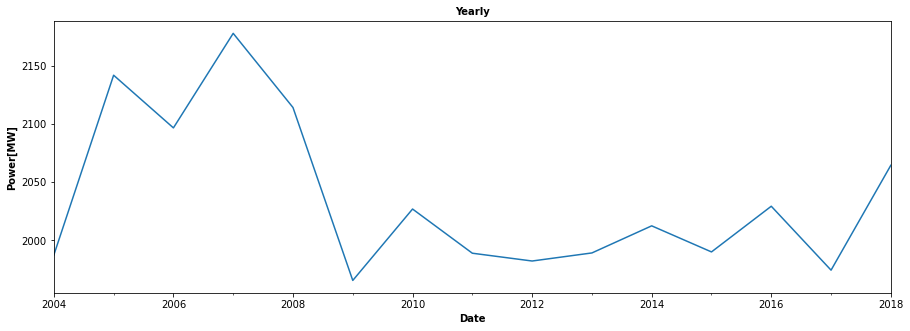

In [11]:
sample_type = 'Daily'
df_daily= SampledDataset(sample_type)

sample_type = 'Monthly'
df_monthly = SampledDataset(sample_type)

sample_type = 'Yearly'
df_yearly= SampledDataset(sample_type)

# **Tests for data stationarity**




**1. Augmented Dickey–Fuller test**

In [12]:
# defining helper functions for stationarity test
def adftest(y_series):
    #Augmented Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(y_series, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)
    print("*************")


In [13]:
adftest(df)
adftest(df_hourly_2017)

Results of Dickey Fuller Test:
Test Statistic                    -22.585100
p-value                             0.000000
#Lags Used                         71.000000
Number of Observations Used    121203.000000
Critical Value (1%)                -3.430404
Critical Value (5%)                -2.861564
Critical Value (10%)               -2.566783
dtype: float64
*************
Results of Dickey Fuller Test:
Test Statistic                -8.859040e+00
p-value                        1.500248e-14
#Lags Used                     3.200000e+01
Number of Observations Used    8.704000e+03
Critical Value (1%)           -3.431102e+00
Critical Value (5%)           -2.861872e+00
Critical Value (10%)          -2.566947e+00
dtype: float64
*************


Accroding to Dickey Fuller Test, p-value =0 <0.05 when considering hourly sampled data, so we can reject the null hypothesis and the dataset is stationary. 

We now plot auto-correlation functions to further test the stationarity. 

**2. Autocorrelation Function**

When data has a trend, the autocorrelations for small lags tend to be large and positive because observations nearby in time are also nearby in size. So the ACF of trended time series tend to have positive values that slowly decrease as the lags increase.

When data is seasonal, the autocorrelations will be larger for the seasonal lags (at multiples of the seasonal frequency) than for other lags.

Ref: https://bookdown.org/rdpeng/timeseriesbook/autocorrelation.html

In [14]:
def plotautocorrelation(df,nlags):
    acf = sm.tsa.acf(df,nlags=nlags,fft=False)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    #fig.title('Time series correlograms')
    ax.stem(acf)
    ax.set_title('ACF')
    ax.set_xlabel('n_lags')
    ax.grid(True)

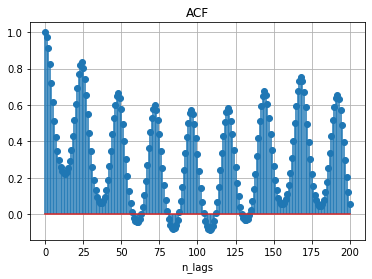

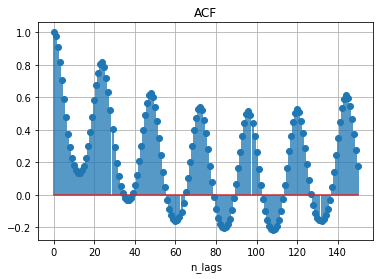

In [15]:
plotautocorrelation(df,nlags=200)
plotautocorrelation(df_hourly_2017,nlags=150)

Based on above auto-correlation plots the series seems non-stationary. So we are gonna assume non-stationarity. There is also seasonal trend with n_lag ~ 25

**3. Time series differentiation**

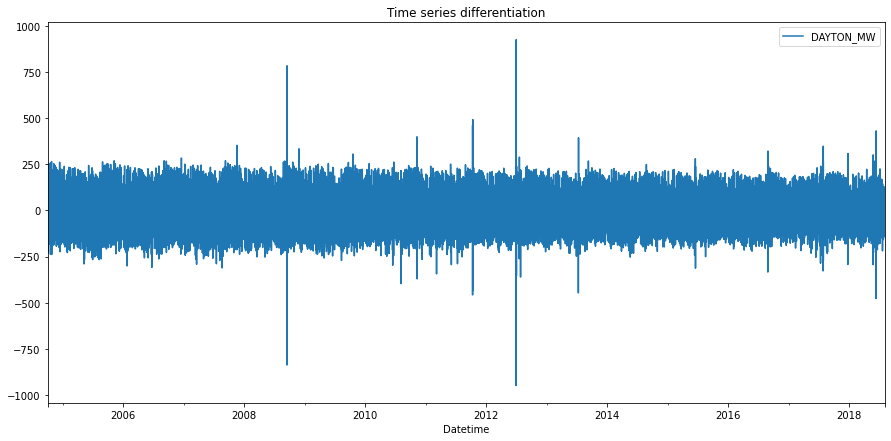

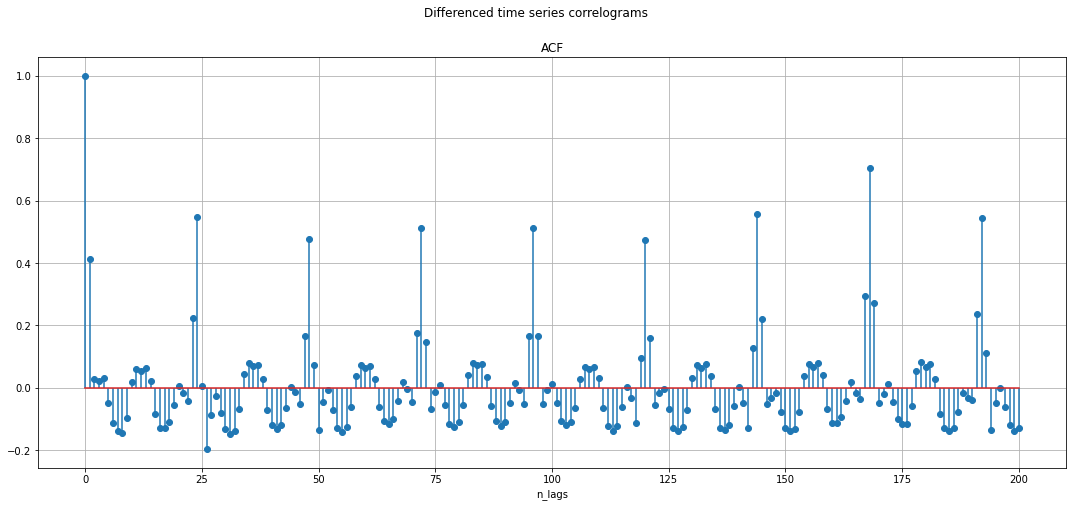

In [16]:
dif = sm.tsa.statespace.tools.diff(df, k_diff=1, k_seasonal_diff=1, seasonal_periods=25)

plt.rcParams["figure.figsize"] = (15,7)
dif.plot()
plt.title('Time series differentiation')
plt.show()

fas_dif = sm.tsa.acf(dif, nlags=200)

fig, ax = plt.subplots(1, 1, figsize=(15,7))
fig.suptitle('Differenced time series correlograms', y=1)
ax.stem(fas_dif)
ax.set_title('ACF')
ax.set_xlabel('n_lags')
ax.grid(True)
plt.tight_layout()
plt.show()

# Part 2 :Time Series Analysis with ARIMA

**Splitting Data for Training and Validation**


In [17]:
training_set= df[df.index <= pd.to_datetime("2015-12-01").to_period("H")]
validation_set= df[df.index > pd.to_datetime("2015-12-01").to_period("H")]

y_train = training_set['DAYTON_MW']
y_validation = validation_set['DAYTON_MW']



**Forecasting**

We will use power consumption in 2019 to test our model.

In [19]:
df_test = pd.read_csv('./Data/DAYTON_hourly_2019.csv')
df_test.head()

df_test= df_test.drop(columns=['datetime_beginning_ept','datetime_ending_utc','datetime_ending_ept','load_area'],axis=1)

df_test= df_test.rename(columns={'datetime_beginning_utc':'Datetime','prelim_load_avg_hourly':'DAYTON_MW'})


df_test.Datetime= pd.to_datetime(df_test.Datetime, format='%m/%d/%Y %I:%M:%S %p') 

Auto ARIMA to get an idea of ARIMA paramters. Though it's very computatioanlly expesnive and not feasible for larger dataset. 

In [ ]:
search_model = pm.arima.auto_arima(y_train,
                                   start_p=1, start_q=1, d=1,
                                   max_p=7, max_q=7, max_d=5,
                                   max_order=None,
                                   m=150,
                                   seasonal=True,
                                   test='adf',
                                   n_jobs=-1,
                                   trace=True,
                                   error_action='ignore')

/opt/conda/lib/python3.7/site-packages/pmdarima/arima/_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Performing stepwise search to minimize aic


Results from auto_arima considering non-seasonality :

Best model:  ARIMA(7,1,1)(0,0,0)        
Total fit time: 1814.022 seconds


In [20]:
p= 7
q= 1
d= 1

s= 25
D= 1
P= 0
Q= 0

In [21]:
ARIMA_model = ARIMA(y_train, order=(p,d,q),seasonal_order=(P,D,Q,s))
ARIMA_model_fit = ARIMA_model.fit()

In [26]:
def mean_absolute_percentage_error(y_true, y_pred): 
    
    """Calculates MAPE given y_true and y_pred"""
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f'The Mean Absolute Percentage Error is: {mape:.2f}')

In [27]:
predcited_set = ARIMA_model_fit.apply(y_validation)
y_pred= predcited_set.fittedvalues

print('Using Validation Dataset:')
print(f'Mean Sqaured Error is: {mean_squared_error(y_validation,y_pred):.2f}')
mean_absolute_percentage_error(y_validation,y_pred)

Using Validation Dataset:
Mean Sqaured Error is: 2765.65
The Mean Absolute Percentage Error is: 1.86


In [28]:
y_test = df_test['DAYTON_MW']
forecasted_set = ARIMA_model_fit.apply(y_test)
y_forecasted= forecasted_set.fittedvalues

print('Using Testing Dataset:')
print(f'Mean Squared Error is: {mean_squared_error(y_forecasted,y_test):.2f}')
mean_absolute_percentage_error(y_test,y_forecasted)

# new dataframe to store forecasted value
df_forecasted = pd.DataFrame()
df_forecasted['Datetime'] = df_test['Datetime']
df_forecasted['DAYTON_MW'] = y_forecasted

Using Testing Dataset:
Mean Squared Error is: 2318.86
The Mean Absolute Percentage Error is: 1.66


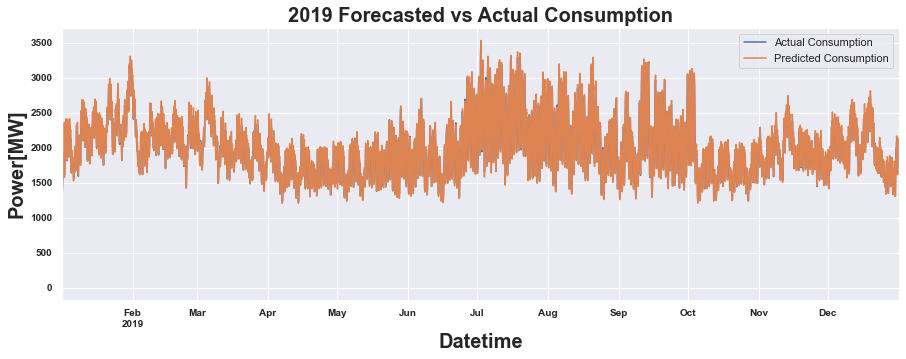

In [29]:
sns.set_theme(style="darkgrid")
ax= df_test.plot(x='Datetime',y='DAYTON_MW',kind='line',figsize=(15, 5))
df_forecasted.plot(x='Datetime',y='DAYTON_MW',kind='line',figsize=(15, 5),ax=ax)
plt.xticks(fontsize=10,fontweight='bold')
plt.yticks(fontsize=10,fontweight='bold')
plt.xlabel('Datetime', fontsize=20,fontweight='bold') 
plt.ylabel('Power[MW]', fontsize=20,fontweight='bold') 
plt.legend(['Actual Consumption','Predicted Consumption'])
plt.title("2019 Forecasted vs Actual Consumption",fontsize=20,fontweight='bold')
plt.show()

# Part 3 :Time Series Analysis with Facebook Prophet

Facebook Prophet is an open-source algorithm for generating time-series models. 

It works best with time series that have strong seasonal effects and several seasons of historical data.

https://facebook.github.io/prophet/

In [30]:
# Format data for prophet model using ds and y
y_train_prophet = y_train.reset_index().rename(columns={'Datetime':'ds','DAYTON_MW':'y'})
y_train_prophet['ds'] = y_train_prophet['ds'].dt.to_timestamp()
display(y_train_prophet.head())


model = Prophet()
model.fit(y_train_prophet)

,ds,y
0,2004-10-01 01:00:00,1621.0
1,2004-10-01 02:00:00,1536.0
2,2004-10-01 03:00:00,1500.0
3,2004-10-01 04:00:00,1434.0
4,2004-10-01 05:00:00,1489.0


02:28:23 - cmdstanpy - INFO - Chain [1] start processing
02:30:19 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
# Predict on validation set with model
y_valid_prophet = y_validation.reset_index().rename(columns={'Datetime':'ds'})
y_valid_prophet['ds'] = y_valid_prophet['ds'].dt.to_timestamp()

y_pred_prophet = model.predict(df=y_valid_prophet)
y_pred_prophet.head()

yhat_prohpet = y_pred_prophet['yhat']
y_prophet_valid = y_valid_prophet['DAYTON_MW']

print('Using Validation Dataset:')

print(f'MSE with Facebook Prophet:{mean_squared_error(yhat_prohpet,y_prophet_valid):.2f}')
mean_absolute_percentage_error(y_prophet_valid, yhat_prohpet)

Using Validation Dataset:
MSE with Facebook Prophet:66817.96
The Mean Absolute Percentage Error is: 9.61


**Forecasting and then comparing with actual data**

In [32]:
# Predict on training set with model
y_test_prophet = df_test.rename(columns={'Datetime':'ds'})
#y_test_prophet['ds'] = y_test_prophet['ds'].dt.to_timestamp()

y_test_prophet.ds= pd.to_datetime(y_test_prophet.ds, format='%m/%d/%Y %I:%M:%S %p') 

y_forecast = model.predict(df=y_test_prophet)

y_forecast_val = pd.DataFrame().assign(ds=y_forecast['ds'], yhat=y_forecast['yhat'])

print('Using Testing Dataset:')
mean_absolute_percentage_error(y_test_prophet['DAYTON_MW'],y_forecast_val['yhat'])

Using Testing Dataset:
The Mean Absolute Percentage Error is: 12.62


Plot the trend, yearly, weekly , and daily seasonality. .

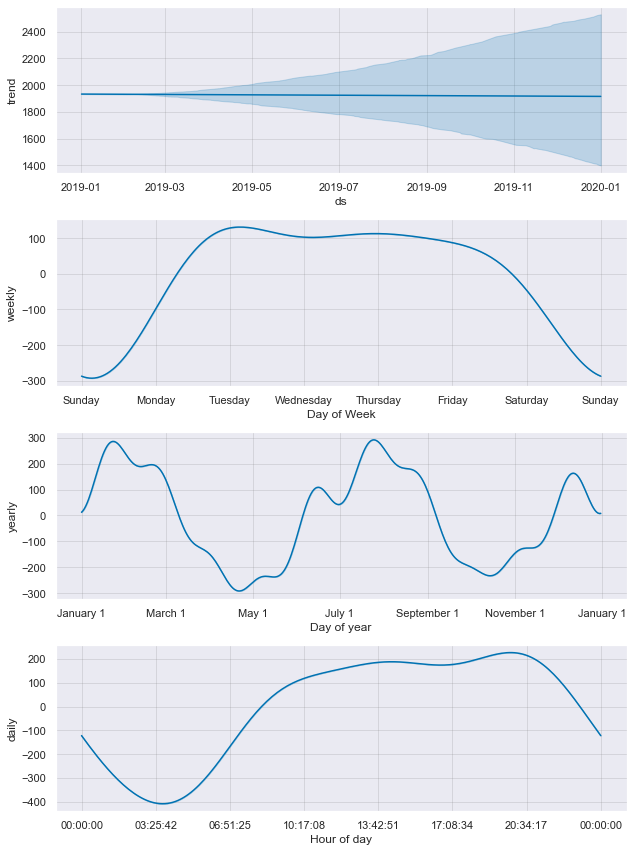

In [33]:
# Plot the components of the model
fig = model.plot_components(y_forecast)

**Plotting forecasted and actual consumption**

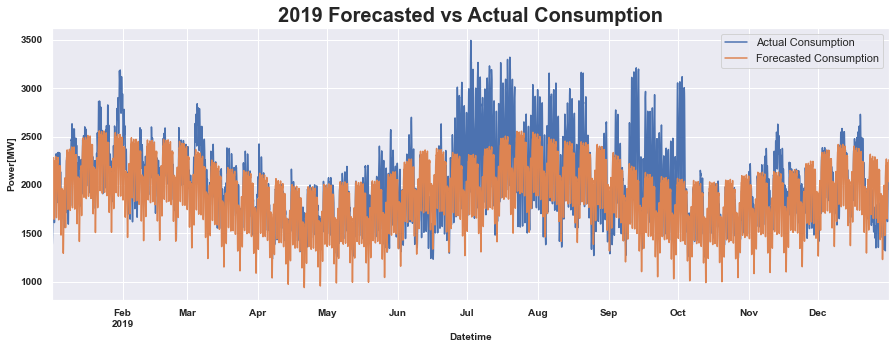

In [34]:
# Plot the forecast with the actuals
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

ax= y_test_prophet.plot(x='ds',y='DAYTON_MW',kind='line',figsize=(15, 5))
y_forecast_val.plot(x='ds',y='yhat',kind='line',figsize=(15, 5),ax=ax)
plt.xticks(fontsize=10,fontweight='bold')
plt.yticks(fontsize=10,fontweight='bold')
plt.xlabel('Datetime', fontsize=10,fontweight='bold') 
plt.ylabel('Power[MW]', fontsize=10,fontweight='bold') 
plt.legend(['Actual Consumption','Forecasted Consumption'])
plt.title("2019 Forecasted vs Actual Consumption",fontsize=20,fontweight='bold')
plt.show()

# Part 4 :Conclusion

1. We used seasonal ARIMA and Facebook's Prophet for time series analysis.
2. Based on Mean Square Error using actual conssumption in 2019, it seems that conventional seasonal ARIMA model performs better than Prophet.